
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from boruta import BorutaPy
from tqdm import tqdm
!pip install Boruta
!pip install Catboost


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Importing and Understanding Data-Set

In [2]:
df = pd.read_csv(r'C:\Users\Nikit\Downloads\Heart_Disease_Prediction.csv')


In [3]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [4]:
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


In [5]:
info = ["age","1: male, 0: female","chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic","resting blood pressure"," serum cholestoral in mg/dl","fasting blood sugar > 120 mg/dl","resting electrocardiographic results (values 0,1,2)"," maximum heart rate achieved","exercise induced angina","oldpeak = ST depression induced by exercise relative to rest","the slope of the peak exercise ST segment","number of major vessels (0-3) colored by flourosopy","thal: 3 = normal; 6 = fixed defect; 7 = reversable defect"]



for i in range(len(info)):
    print(df.columns[i]+":\t\t\t"+info[i])

Age:			age
Sex:			1: male, 0: female
Chest pain type:			chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic
BP:			resting blood pressure
Cholesterol:			 serum cholestoral in mg/dl
FBS over 120:			fasting blood sugar > 120 mg/dl
EKG results:			resting electrocardiographic results (values 0,1,2)
Max HR:			 maximum heart rate achieved
Exercise angina:			exercise induced angina
ST depression:			oldpeak = ST depression induced by exercise relative to rest
Slope of ST:			the slope of the peak exercise ST segment
Number of vessels fluro:			number of major vessels (0-3) colored by flourosopy
Thallium:			thal: 3 = normal; 6 = fixed defect; 7 = reversable defect


In [6]:
df.isnull().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

# Defining  Function

In [7]:
def generate_metadata(dataframe):
    """
    Generates a DataFrame containing metadata for the columns of the provided DataFrame.

    :param dataframe: DataFrame for which metadata will be generated.
    :return: DataFrame containing metadata.
    """

    # Collection of basic metadata
    metadata = pd.DataFrame({
        'variable': dataframe.columns,
        'type': dataframe.dtypes,
        'null_count': dataframe.isnull().sum(),
        'null_percent': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinality': dataframe.nunique(),
    })
#     metadata = metadata.sort_values(by='type')
    metadata = metadata.reset_index(drop=True)

    return metadata

In [8]:
def scale_numeric_columns(dataframe, method='normalize'):
    """
    Scales (normalizes or standardizes) the numeric columns in the provided DataFrame.

    :param dataframe: The DataFrame containing numeric columns to be scaled.
    :param method: The scaling method to use ('normalize' or 'standardize'). Default is 'normalize'.
    :return: A new DataFrame with the selected numeric columns scaled as specified.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    df_scaled = dataframe.copy()
    
    # Select numeric columns based on data type
    numeric_columns = df_scaled.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    
    if method == 'normalize':
        # Initialize Min-Max Scaler for normalization
        scaler = MinMaxScaler()
    elif method == 'standardize':
        # Initialize StandardScaler for standardization
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid method. Use 'normalize' or 'standardize'.")
    
    # Apply the chosen scaler to the selected numeric columns
    df_scaled[numeric_columns] = scaler.fit_transform(df_scaled[numeric_columns])
    
    return df_scaled

In [9]:
def select_features_by_variance_threshold(dataframe, variance_threshold=0):
    """
    Selects features from the provided DataFrame based on a variance threshold.

    :param dataframe: The DataFrame containing features to be selected.
    :param variance_threshold: The minimum variance required for a feature to be retained. Default is 0.
    :return: A new DataFrame with selected features.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    df_selected = dataframe.copy()

    # Initialize VarianceThreshold selector
    selector = VarianceThreshold(variance_threshold)

    # Fit and transform the selector on the DataFrame
    selected_features = selector.fit_transform(df_selected)

    # Get the selected feature names
    selected_feature_names = df_selected.columns[selector.get_support()]

    # Print selected features
    print("Selected Features:", selected_feature_names.tolist())

    # Discarded feature names
    discarded_feature_names = df_selected.columns[~selector.get_support()]

    # Print discarded features (if needed)
    print("Discarded Features:", discarded_feature_names.tolist())

    # Update the DataFrame with selected features
    df_selected = df_selected[selected_feature_names]

    return df_selected

In [10]:
def select_features_by_pca(dataframe, target, n_components=5, top_n=1):
    """
    Select features using Principal Component Analysis (PCA).

    :param dataframe: The DataFrame containing features to be selected.
    :param target: The name of the target column.
    :param n_components: The number of principal components to retain. Default is 5.
    :param top_n: The number of top features to select from each principal component. Default is 1.
    :return: A DataFrame containing selected features and the target column.
    """
    # Split the DataFrame into X (features) and y (target)
    X = dataframe.drop(columns=[target])
    y = dataframe[target]
    
    # Initialize PCA with the specified number of components
    pca_limited = PCA(n_components=n_components)
    
    # Fit PCA on the feature matrix (X)
    pca_limited.fit(X)
    
    # Get the principal components
    pca_limited_components = pca_limited.components_
    
    # Create a DataFrame to store the principal components
    pca_limited_features = pd.DataFrame(pca_limited_components, columns=X.columns,
                                        index=['PC'+str(i) for i in range(1, pca_limited_components.shape[0]+1)]).transpose()
    
    # Initialize a dictionary to store top features for each principal component
    top_components = {}
    
    # Loop through each principal component
    for component in pca_limited_features.columns:
        # Sort the components by absolute value in descending order
        sorted_components = pca_limited_features[component].abs().sort_values(ascending=False)
        
        # Select the top 'top_n' features
        top_components[component] = sorted_components.index[:top_n].tolist()
    
    # Create a list of selected features by combining top features from all principal components
    list_select_pca = list(set([item for sublist in top_components.values() for item in sublist]))
    
    # Print selected and discarded columns
    print("Selected Columns:", list_select_pca)
    print("Discarded Columns:", [col for col in X.columns if col not in list_select_pca])
    
    # Create a new DataFrame with selected features and the target column
    df_selected = dataframe[list_select_pca + [target]]
    
    return df_selected


# Feature Enginerring

In [11]:
df_heart_disease_original = pd.read_csv(r'C:\Users\Nikit\Downloads\Heart_Disease_Prediction.csv')
df_heart_disease_original['Heart Disease'] = df_heart_disease_original['Heart Disease'].replace({'Absence': 0, 'Presence': 1})
df_heart_disease_original

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


In [12]:
df_metadata_original = generate_metadata(df_heart_disease_original)
df_metadata_original

,variable,type,null_count,null_percent,cardinality
0,Age,int64,0,0.0,41
1,Sex,int64,0,0.0,2
2,Chest pain type,int64,0,0.0,4
3,BP,int64,0,0.0,47
4,Cholesterol,int64,0,0.0,144
5,FBS over 120,int64,0,0.0,2
6,EKG results,int64,0,0.0,3
7,Max HR,int64,0,0.0,90
8,Exercise angina,int64,0,0.0,2
9,ST depression,float64,0,0.0,39


In [13]:
df_heart_disease_preparation = df_heart_disease_original.drop(axis=1,columns = 'Heart Disease')
df_heart_disease_preparation

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6


In [14]:
df_metadata_preparation = generate_metadata(df_heart_disease_preparation)
df_metadata_preparation

,variable,type,null_count,null_percent,cardinality
0,Age,int64,0,0.0,41
1,Sex,int64,0,0.0,2
2,Chest pain type,int64,0,0.0,4
3,BP,int64,0,0.0,47
4,Cholesterol,int64,0,0.0,144
5,FBS over 120,int64,0,0.0,2
6,EKG results,int64,0,0.0,3
7,Max HR,int64,0,0.0,90
8,Exercise angina,int64,0,0.0,2
9,ST depression,float64,0,0.0,39


In [15]:
df_heart_disease_preparation_normal = scale_numeric_columns(df_heart_disease_preparation) # default method='normalize'
df_heart_disease_preparation_normal

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,0.854167,1.0,1.000000,0.339623,0.447489,0.0,1.0,0.290076,0.0,0.387097,0.5,1.000000,0.00
1,0.791667,0.0,0.666667,0.198113,1.000000,0.0,1.0,0.679389,0.0,0.258065,0.5,0.000000,1.00
2,0.583333,1.0,0.333333,0.283019,0.308219,0.0,0.0,0.534351,0.0,0.048387,0.0,0.000000,1.00
3,0.729167,1.0,1.000000,0.320755,0.312785,0.0,0.0,0.259542,1.0,0.032258,0.5,0.333333,1.00
4,0.937500,0.0,0.333333,0.245283,0.326484,0.0,1.0,0.381679,1.0,0.032258,0.0,0.333333,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.479167,1.0,0.666667,0.735849,0.166667,1.0,0.0,0.694656,0.0,0.080645,0.0,0.000000,1.00
266,0.312500,1.0,0.333333,0.245283,0.312785,0.0,0.0,0.778626,0.0,0.000000,0.0,0.000000,1.00
267,0.562500,0.0,0.333333,0.433962,0.383562,0.0,1.0,0.625954,0.0,0.209677,0.5,0.000000,0.00
268,0.583333,1.0,1.000000,0.433962,0.150685,0.0,0.0,0.587786,0.0,0.064516,0.5,0.000000,0.75


In [16]:
df_metadata_normal = generate_metadata(df_heart_disease_preparation_normal)
df_metadata_normal

,variable,type,null_count,null_percent,cardinality
0,Age,float64,0,0.0,41
1,Sex,float64,0,0.0,2
2,Chest pain type,float64,0,0.0,4
3,BP,float64,0,0.0,47
4,Cholesterol,float64,0,0.0,144
5,FBS over 120,float64,0,0.0,2
6,EKG results,float64,0,0.0,3
7,Max HR,float64,0,0.0,90
8,Exercise angina,float64,0,0.0,2
9,ST depression,float64,0,0.0,39


Feature Standardization by Standard Scaling

In [17]:
df_heart_disease_preparation_standard = scale_numeric_columns(df_heart_disease_preparation, 'standardize') # default method='normalize'
df_heart_disease_preparation_standard

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,1.712094,0.689500,0.870928,-0.075410,1.402212,-0.417029,0.981664,-1.759208,-0.701222,1.181012,0.676419,2.472682,-0.875706
1,1.382140,-1.450327,-0.183559,-0.916759,6.093004,-0.417029,0.981664,0.446409,-0.701222,0.481153,0.676419,-0.711535,1.189277
2,0.282294,0.689500,-1.238045,-0.411950,0.219823,-0.417029,-1.026285,-0.375291,-0.701222,-0.656118,-0.954234,-0.711535,1.189277
3,1.052186,0.689500,0.870928,-0.187590,0.258589,-0.417029,-1.026285,-1.932198,1.426081,-0.743600,0.676419,0.349871,1.189277
4,2.152032,-1.450327,-1.238045,-0.636310,0.374890,-0.417029,0.981664,-1.240239,1.426081,-0.743600,-0.954234,0.349871,-0.875706
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,-0.267629,0.689500,-0.183559,2.280369,-0.981951,2.397916,-1.026285,0.532904,-0.701222,-0.481153,-0.954234,-0.711535,1.189277
266,-1.147506,0.689500,-1.238045,-0.636310,0.258589,-0.417029,-1.026285,1.008625,-0.701222,-0.918565,-0.954234,-0.711535,1.189277
267,0.172309,-1.450327,-1.238045,0.485490,0.859476,-0.417029,0.981664,0.143677,-0.701222,0.218706,0.676419,-0.711535,-0.875706
268,0.282294,0.689500,0.870928,0.485490,-1.117635,-0.417029,-1.026285,-0.072560,-0.701222,-0.568636,0.676419,-0.711535,0.673032


In [18]:
df_metadata_standard = generate_metadata(df_heart_disease_preparation_standard)
df_metadata_standard


,variable,type,null_count,null_percent,cardinality
0,Age,float64,0,0.0,41
1,Sex,float64,0,0.0,2
2,Chest pain type,float64,0,0.0,4
3,BP,float64,0,0.0,47
4,Cholesterol,float64,0,0.0,144
5,FBS over 120,float64,0,0.0,2
6,EKG results,float64,0,0.0,3
7,Max HR,float64,0,0.0,90
8,Exercise angina,float64,0,0.0,2
9,ST depression,float64,0,0.0,39


Feature Selection

In [19]:
df_heart_disease_selection_normal = pd.merge(df_heart_disease_preparation_normal, 
df_heart_disease_original[['Heart Disease']], left_index=True, right_index=True, how='inner')
df_heart_disease_selection_normal

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0.854167,1.0,1.000000,0.339623,0.447489,0.0,1.0,0.290076,0.0,0.387097,0.5,1.000000,0.00,1
1,0.791667,0.0,0.666667,0.198113,1.000000,0.0,1.0,0.679389,0.0,0.258065,0.5,0.000000,1.00,0
2,0.583333,1.0,0.333333,0.283019,0.308219,0.0,0.0,0.534351,0.0,0.048387,0.0,0.000000,1.00,1
3,0.729167,1.0,1.000000,0.320755,0.312785,0.0,0.0,0.259542,1.0,0.032258,0.5,0.333333,1.00,0
4,0.937500,0.0,0.333333,0.245283,0.326484,0.0,1.0,0.381679,1.0,0.032258,0.0,0.333333,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.479167,1.0,0.666667,0.735849,0.166667,1.0,0.0,0.694656,0.0,0.080645,0.0,0.000000,1.00,0
266,0.312500,1.0,0.333333,0.245283,0.312785,0.0,0.0,0.778626,0.0,0.000000,0.0,0.000000,1.00,0
267,0.562500,0.0,0.333333,0.433962,0.383562,0.0,1.0,0.625954,0.0,0.209677,0.5,0.000000,0.00,0
268,0.583333,1.0,1.000000,0.433962,0.150685,0.0,0.0,0.587786,0.0,0.064516,0.5,0.000000,0.75,0


In [20]:
df_heart_disease_selection_standard = pd.merge(df_heart_disease_preparation_standard, 
df_heart_disease_original[['Heart Disease']], left_index=True, right_index=True, how='inner')
df_heart_disease_selection_standard

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.712094,0.689500,0.870928,-0.075410,1.402212,-0.417029,0.981664,-1.759208,-0.701222,1.181012,0.676419,2.472682,-0.875706,1
1,1.382140,-1.450327,-0.183559,-0.916759,6.093004,-0.417029,0.981664,0.446409,-0.701222,0.481153,0.676419,-0.711535,1.189277,0
2,0.282294,0.689500,-1.238045,-0.411950,0.219823,-0.417029,-1.026285,-0.375291,-0.701222,-0.656118,-0.954234,-0.711535,1.189277,1
3,1.052186,0.689500,0.870928,-0.187590,0.258589,-0.417029,-1.026285,-1.932198,1.426081,-0.743600,0.676419,0.349871,1.189277,0
4,2.152032,-1.450327,-1.238045,-0.636310,0.374890,-0.417029,0.981664,-1.240239,1.426081,-0.743600,-0.954234,0.349871,-0.875706,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,-0.267629,0.689500,-0.183559,2.280369,-0.981951,2.397916,-1.026285,0.532904,-0.701222,-0.481153,-0.954234,-0.711535,1.189277,0
266,-1.147506,0.689500,-1.238045,-0.636310,0.258589,-0.417029,-1.026285,1.008625,-0.701222,-0.918565,-0.954234,-0.711535,1.189277,0
267,0.172309,-1.450327,-1.238045,0.485490,0.859476,-0.417029,0.981664,0.143677,-0.701222,0.218706,0.676419,-0.711535,-0.875706,0
268,0.282294,0.689500,0.870928,0.485490,-1.117635,-0.417029,-1.026285,-0.072560,-0.701222,-0.568636,0.676419,-0.711535,0.673032,0


Feature Eliminated by Variance

In [21]:
df_heart_disease_selection_normal = select_features_by_variance_threshold(df_heart_disease_selection_normal)
df_heart_disease_selection_normal

Selected Features: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']
Discarded Features: []


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0.854167,1.0,1.000000,0.339623,0.447489,0.0,1.0,0.290076,0.0,0.387097,0.5,1.000000,0.00,1
1,0.791667,0.0,0.666667,0.198113,1.000000,0.0,1.0,0.679389,0.0,0.258065,0.5,0.000000,1.00,0
2,0.583333,1.0,0.333333,0.283019,0.308219,0.0,0.0,0.534351,0.0,0.048387,0.0,0.000000,1.00,1
3,0.729167,1.0,1.000000,0.320755,0.312785,0.0,0.0,0.259542,1.0,0.032258,0.5,0.333333,1.00,0
4,0.937500,0.0,0.333333,0.245283,0.326484,0.0,1.0,0.381679,1.0,0.032258,0.0,0.333333,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.479167,1.0,0.666667,0.735849,0.166667,1.0,0.0,0.694656,0.0,0.080645,0.0,0.000000,1.00,0
266,0.312500,1.0,0.333333,0.245283,0.312785,0.0,0.0,0.778626,0.0,0.000000,0.0,0.000000,1.00,0
267,0.562500,0.0,0.333333,0.433962,0.383562,0.0,1.0,0.625954,0.0,0.209677,0.5,0.000000,0.00,0
268,0.583333,1.0,1.000000,0.433962,0.150685,0.0,0.0,0.587786,0.0,0.064516,0.5,0.000000,0.75,0


Feature Eliminated by Principal Component Analysis

In [22]:
df_heart_disease_pca_standard = select_features_by_pca(df_heart_disease_selection_standard, 'Heart Disease') # default n_components=5 and top_n=1
df_heart_disease_pca_standard

Selected Columns: ['EKG results', 'Slope of ST', 'Sex', 'ST depression', 'FBS over 120']
Discarded Columns: ['Age', 'Chest pain type', 'BP', 'Cholesterol', 'Max HR', 'Exercise angina', 'Number of vessels fluro', 'Thallium']


,EKG results,Slope of ST,Sex,ST depression,FBS over 120,Heart Disease
0,0.981664,0.676419,0.689500,1.181012,-0.417029,1
1,0.981664,0.676419,-1.450327,0.481153,-0.417029,0
2,-1.026285,-0.954234,0.689500,-0.656118,-0.417029,1
3,-1.026285,0.676419,0.689500,-0.743600,-0.417029,0
4,0.981664,-0.954234,-1.450327,-0.743600,-0.417029,0
...,...,...,...,...,...,...
265,-1.026285,-0.954234,0.689500,-0.481153,2.397916,0
266,-1.026285,-0.954234,0.689500,-0.918565,-0.417029,0
267,0.981664,0.676419,-1.450327,0.218706,-0.417029,0
268,-1.026285,0.676419,0.689500,-0.568636,-0.417029,0


# Exploratory Data Analysis

In [23]:
import pandas as pd

# Load your dataset
df = pd.read_csv(r'C:\Users\Nikit\Downloads\Heart_Disease_Prediction.csv')

# Display the column names
print(df.columns)


Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
       'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
      dtype='object')


In [24]:
df.corr()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
Age,1.000000,-0.094401,0.096920,0.273053,0.220056,0.123458,0.128171,-0.402215,0.098297,0.194234,0.159774,0.356081,0.106100
Sex,-0.094401,1.000000,0.034636,-0.062693,-0.201647,0.042140,0.039253,-0.076101,0.180022,0.097412,0.050545,0.086830,0.391046
Chest pain type,0.096920,0.034636,1.000000,-0.043196,0.090465,-0.098537,0.074325,-0.317682,0.353160,0.167244,0.136900,0.225890,0.262659
BP,0.273053,-0.062693,-0.043196,1.000000,0.173019,0.155681,0.116157,-0.039136,0.082793,0.222800,0.142472,0.085697,0.132045
Cholesterol,0.220056,-0.201647,0.090465,0.173019,1.000000,0.025186,0.167652,-0.018739,0.078243,0.027709,-0.005755,0.126541,0.028836
FBS over 120,0.123458,0.042140,-0.098537,0.155681,0.025186,1.000000,0.053499,0.022494,-0.004107,-0.025538,0.044076,0.123774,0.049237
EKG results,0.128171,0.039253,0.074325,0.116157,0.167652,0.053499,1.000000,-0.074628,0.095098,0.120034,0.160614,0.114368,0.007337
Max HR,-0.402215,-0.076101,-0.317682,-0.039136,-0.018739,0.022494,-0.074628,1.000000,-0.380719,-0.349045,-0.386847,-0.265333,-0.253397
Exercise angina,0.098297,0.180022,0.353160,0.082793,0.078243,-0.004107,0.095098,-0.380719,1.000000,0.274672,0.255908,0.153347,0.321449
ST depression,0.194234,0.097412,0.167244,0.222800,0.027709,-0.025538,0.120034,-0.349045,0.274672,1.000000,0.609712,0.255005,0.324333


(13.5, -0.5)

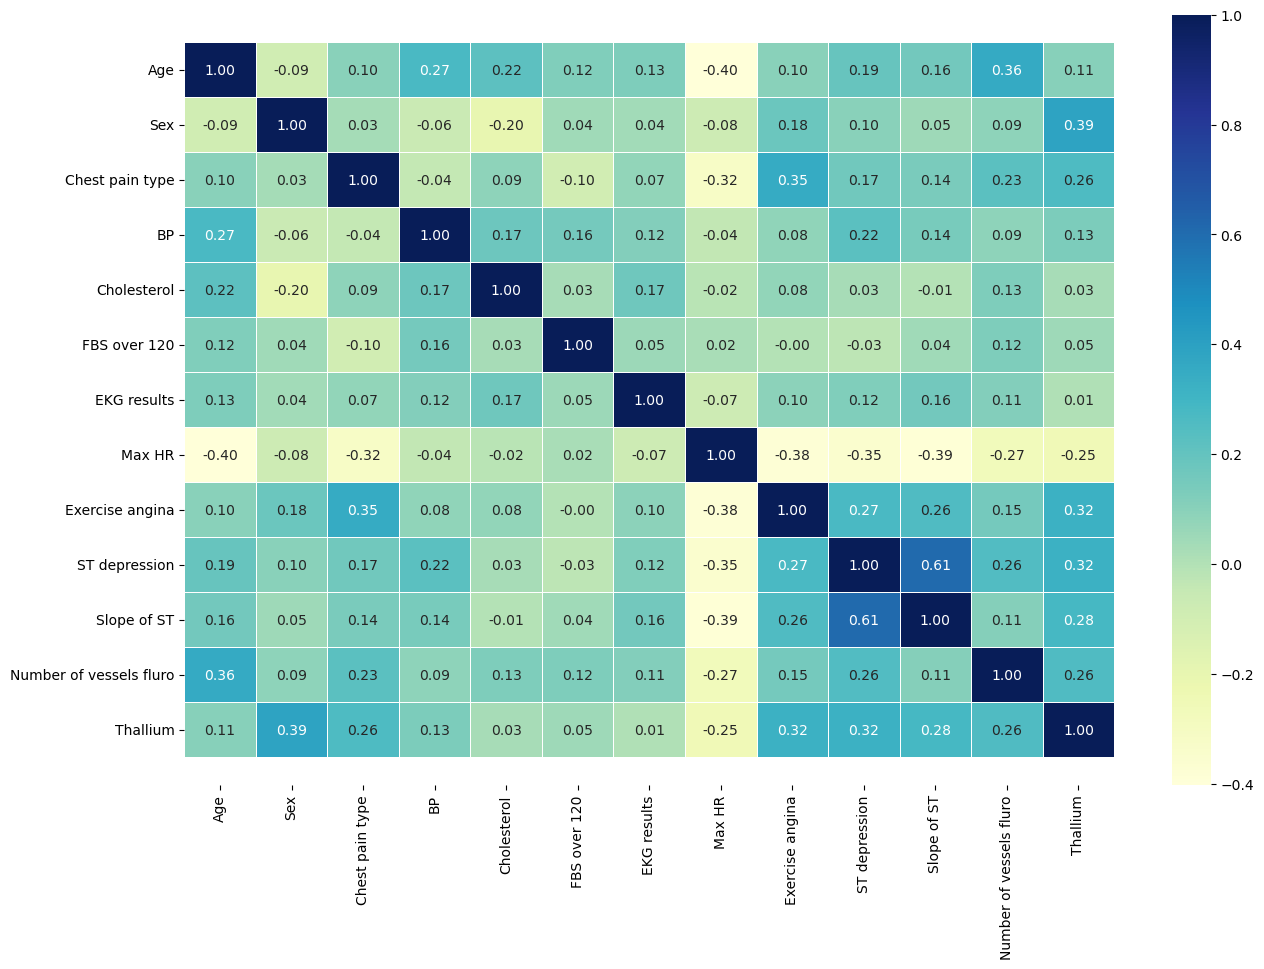

In [25]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

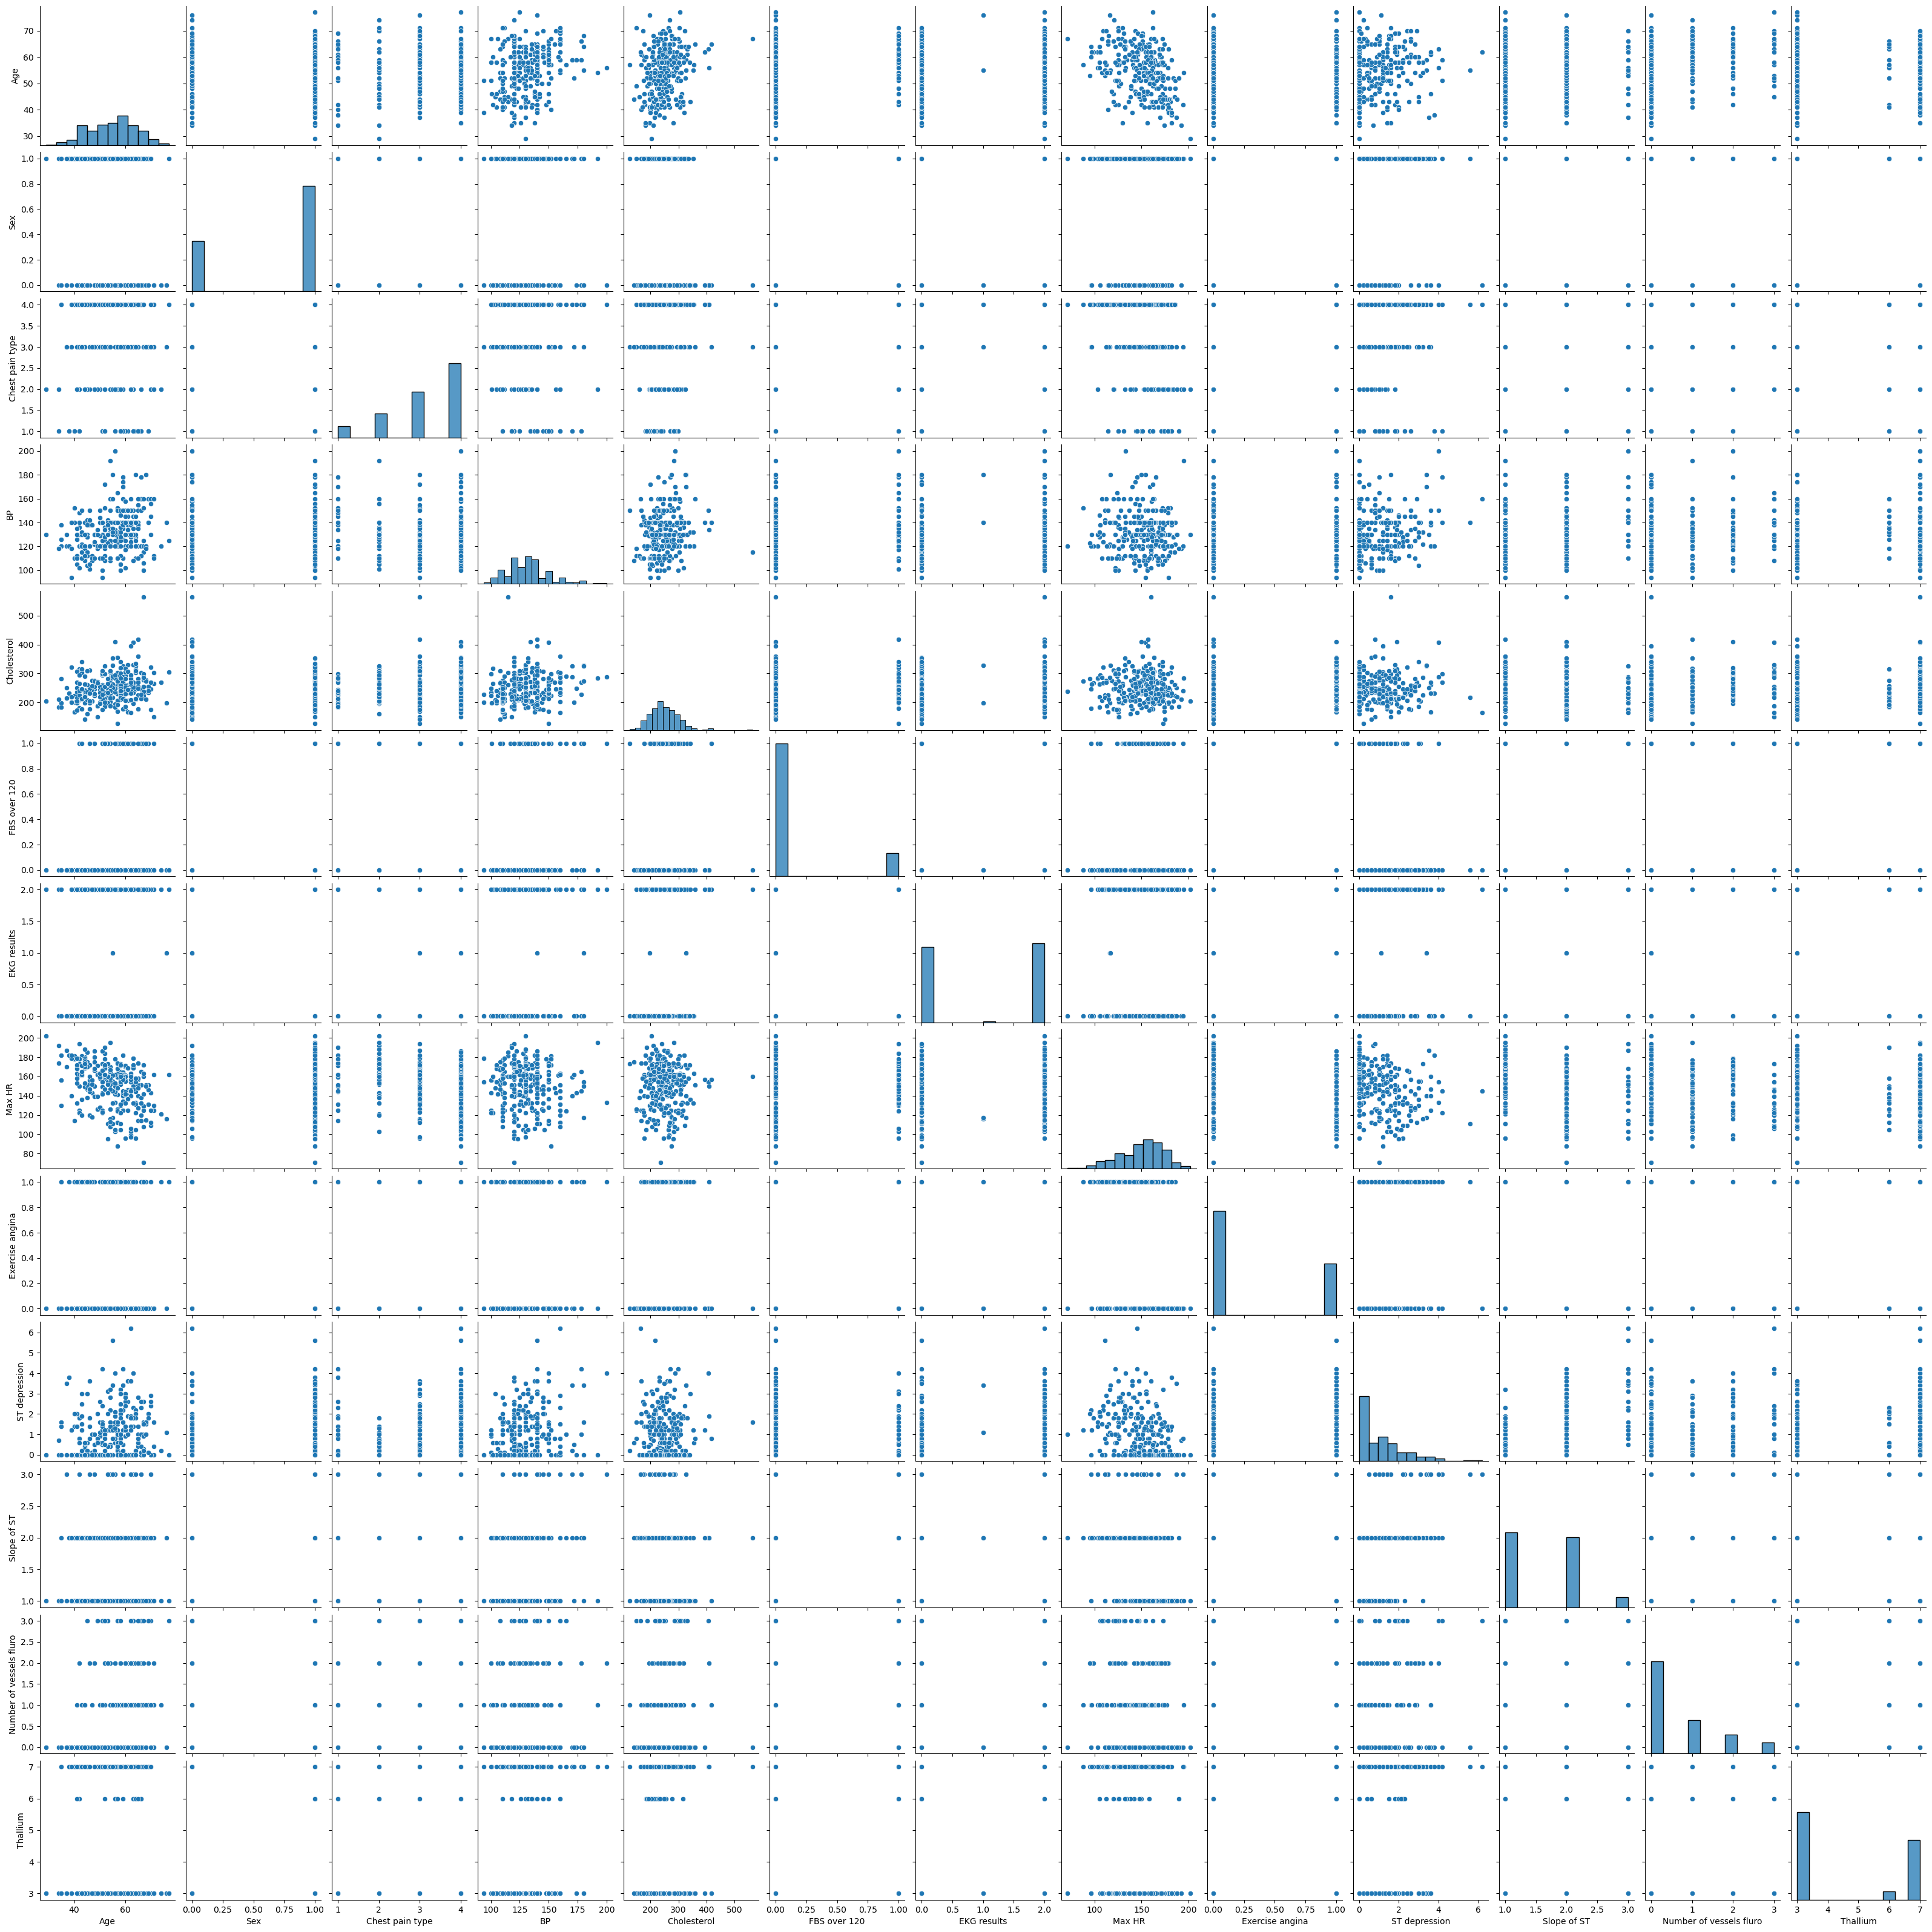

In [26]:
numerical_columns = df.select_dtypes(include='number').columns
columns_to_plot = ['Heart Disease'] + numerical_columns.tolist()
sns.pairplot(df[columns_to_plot])
plt.show()


Absence     150
Presence    120
Name: Heart Disease, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


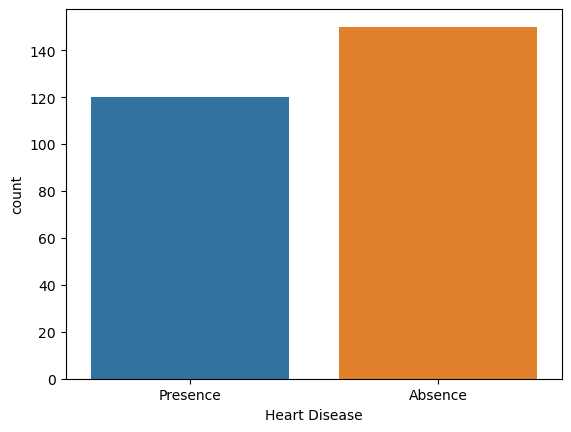

In [27]:
y = df["Heart Disease"]

sns.countplot(y)


target_temp = df["Heart Disease"].value_counts()

print(target_temp)

In [28]:
print("Percentage of patience without heart problems: "+str(round(target_temp[0]*100/303,2)))
print("Percentage of patience with heart problems: "+str(round(target_temp[1]*100/303,2)))


Percentage of patience without heart problems: 49.5
Percentage of patience with heart problems: 39.6


We'll analyse 'sex','chest pain type','FBS over 120','Cholestrol','Thallium'

Analysing the 'Sex' feature

In [29]:
df["Sex"].unique()

array([1, 0], dtype=int64)

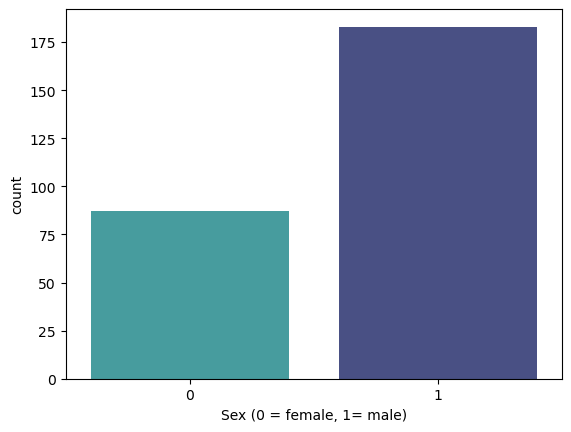

In [30]:
sns.countplot(x='Sex', data=df, palette="mako_r")
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sex', ylabel='Heart Disease'>

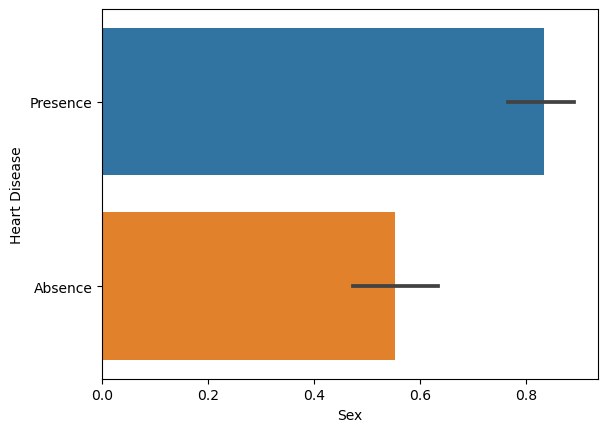

In [31]:
sns.barplot(df["Sex"],y)

In [32]:
countFemale = len(df[df.Sex == 0])
countMale = len(df[df.Sex == 1])
print("Percentage of Female Patients: {:.2f}%".format((countFemale / (len(df.Sex))*100)))
print("Percentage of Male Patients: {:.2f}%".format((countMale / (len(df.Sex))*100)))

Percentage of Female Patients: 32.22%
Percentage of Male Patients: 67.78%


 Analysing the Chest Pain Type

In [33]:
df["Chest pain type"].unique()

array([4, 3, 2, 1], dtype=int64)

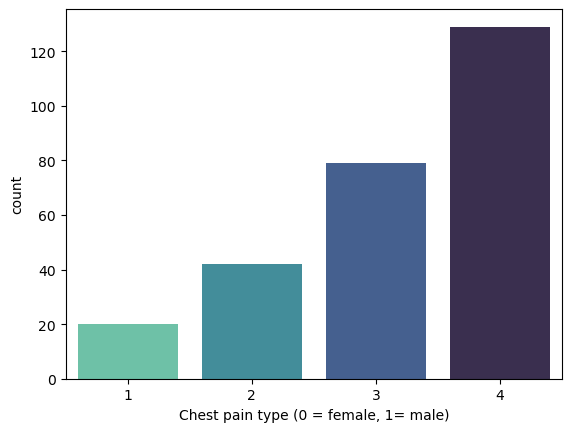

In [34]:
sns.countplot(x='Chest pain type', data=df, palette="mako_r")
plt.xlabel("Chest pain type (0 = female, 1= male)")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Chest pain type', ylabel='Heart Disease'>

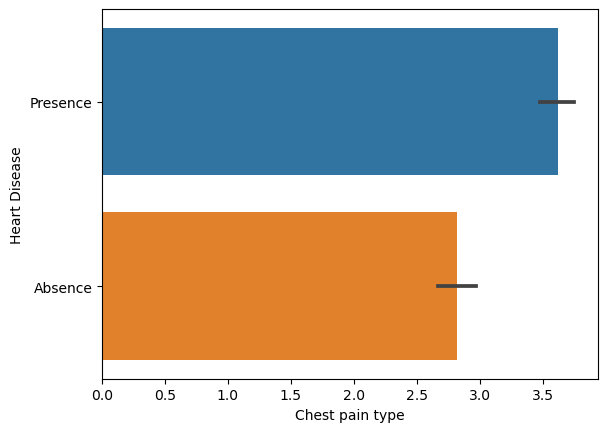

In [35]:
sns.barplot(df["Chest pain type"],y)

In [36]:
countFemale = len(df[df['Chest pain type'] == 0])
countMale = len(df[df['Chest pain type'] == 1])
print("Percentage of Female Patients: {:.2f}%".format((countFemale / (len(df.Sex))*100)))
print("Percentage of Male Patients: {:.2f}%".format((countMale / (len(df.Sex))*100)))

Percentage of Female Patients: 0.00%
Percentage of Male Patients: 7.41%


Analysing the FBS over 120

In [37]:
df["FBS over 120"].unique()

array([0, 1], dtype=int64)

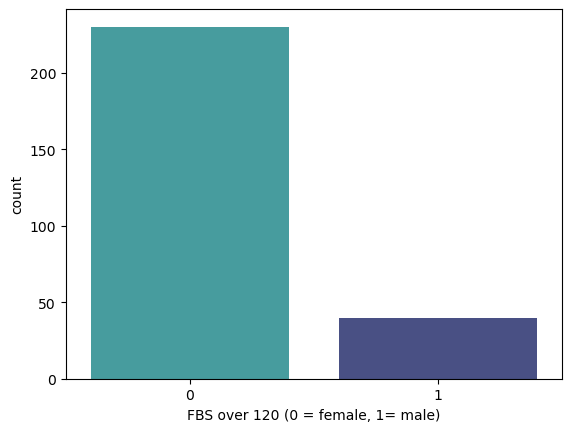

In [38]:
sns.countplot(x='FBS over 120', data=df, palette="mako_r")
plt.xlabel("FBS over 120 (0 = female, 1= male)")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FBS over 120', ylabel='Heart Disease'>

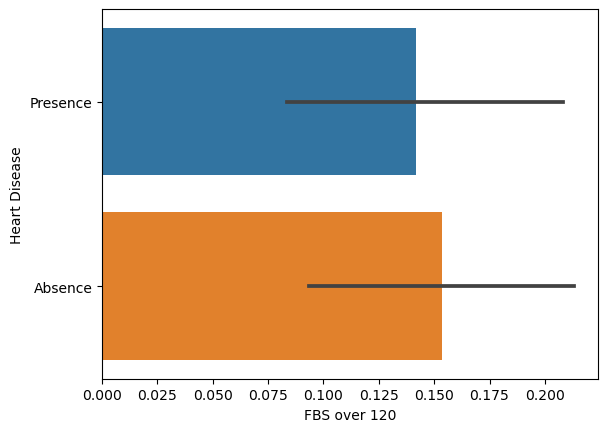

In [39]:
sns.barplot(df["FBS over 120"],y)

In [40]:
countFemale = len(df[df['FBS over 120'] == 0])
countMale = len(df[df['FBS over 120'] == 1])
print("Percentage of Female Patients: {:.2f}%".format((countFemale / (len(df.Sex))*100)))
print("Percentage of Male Patients: {:.2f}%".format((countMale / (len(df.Sex))*100)))

Percentage of Female Patients: 85.19%
Percentage of Male Patients: 14.81%


Analysing the Cholestrol

In [41]:
df["Cholesterol"].unique()

array([322, 564, 261, 263, 269, 177, 256, 239, 293, 407, 234, 226, 235,
       303, 149, 311, 203, 211, 199, 229, 245, 204, 288, 275, 243, 295,
       230, 265, 228, 215, 326, 200, 207, 273, 180, 222, 223, 209, 233,
       197, 218, 246, 225, 315, 205, 417, 195, 198, 166, 178, 249, 281,
       126, 305, 240, 276, 319, 242, 260, 354, 309, 208, 236, 270, 214,
       201, 244, 306, 221, 330, 266, 206, 212, 302, 313, 141, 237, 289,
       254, 274, 258, 160, 327, 304, 271, 283, 188, 286, 360, 267, 196,
       232, 277, 210, 213, 282, 167, 224, 268, 250, 219, 217, 308, 193,
       231, 262, 259, 325, 299, 182, 294, 298, 409, 172, 184, 394, 174,
       255, 248, 300, 318, 216, 252, 227, 220, 168, 183, 341, 186, 307,
       164, 257, 321, 264, 253, 185, 290, 175, 353, 335, 247, 340, 284,
       192], dtype=int64)

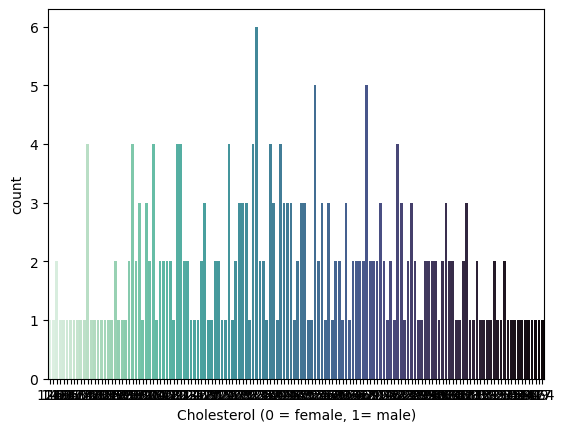

In [42]:
sns.countplot(x='Cholesterol', data=df, palette="mako_r")
plt.xlabel("Cholesterol (0 = female, 1= male)")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Cholesterol', ylabel='Heart Disease'>

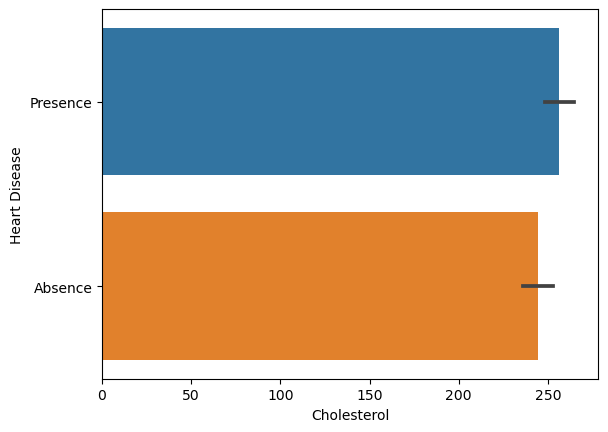

In [43]:
sns.barplot(df["Cholesterol"],y)

In [44]:
countFemale = len(df[df['Cholesterol'] == 0])
countMale = len(df[df['Cholesterol'] == 1])
print("Percentage of Female Patients: {:.2f}%".format((countFemale / (len(df.Sex))*100)))
print("Percentage of Male Patients: {:.2f}%".format((countMale / (len(df.Sex))*100)))

Percentage of Female Patients: 0.00%
Percentage of Male Patients: 0.00%


Analysing for Thallium

In [45]:
df["Thallium"].unique()

array([3, 7, 6], dtype=int64)

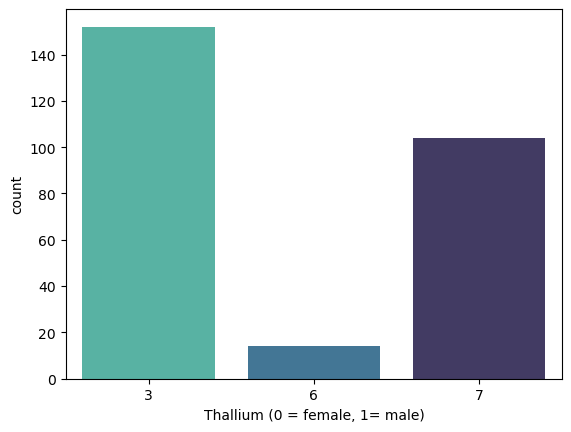

In [46]:
sns.countplot(x='Thallium', data=df, palette="mako_r")
plt.xlabel("Thallium (0 = female, 1= male)")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Thallium', ylabel='Heart Disease'>

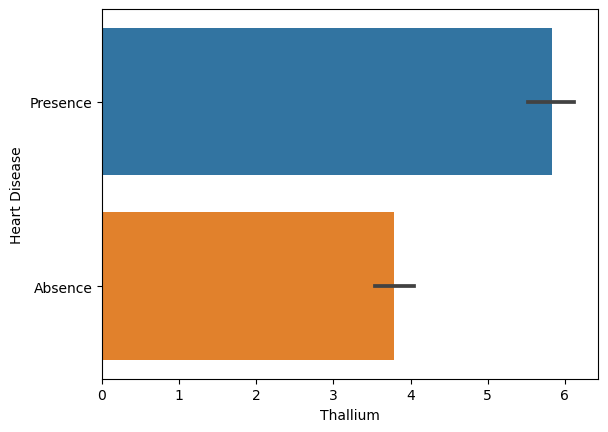

In [47]:
sns.barplot(df["Thallium"],y)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Thallium', ylabel='Density'>

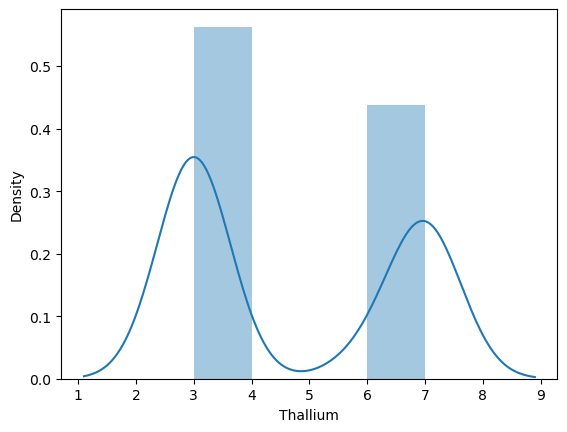

In [48]:
sns.distplot(df["Thallium"])

Train Test Split

In [49]:
from sklearn.model_selection import train_test_split

predictors = df.drop("Heart Disease",axis=1)
target = df["Heart Disease"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

In [50]:
X_train.shape

(216, 13)

In [51]:
X_test.shape

(54, 13)

In [52]:
Y_train.shape

(216,)

In [53]:
Y_test.shape

(54,)

# Model Simulation

In [54]:
from sklearn.metrics import accuracy_score

In [55]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,Y_train)

Y_pred_lr = lr.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
Y_pred_lr.shape

(54,)

In [57]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)

print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")

The accuracy score achieved using Logistic Regression is: 83.33 %


Naive Bayes

In [58]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,Y_train)

Y_pred_nb = nb.predict(X_test)

In [59]:
Y_pred_nb.shape

(54,)

In [60]:
score_nb = round(accuracy_score(Y_pred_nb,Y_test)*100,2)

print("The accuracy score achieved using Naive Bayes is: "+str(score_nb)+" %")

The accuracy score achieved using Naive Bayes is: 74.07 %


Support Vector Machine

In [61]:
from sklearn import svm

sv = svm.SVC(kernel='linear')

sv.fit(X_train, Y_train)

Y_pred_svm = sv.predict(X_test)

In [62]:
Y_pred_svm.shape

(54,)

In [63]:
score_svm = round(accuracy_score(Y_pred_svm,Y_test)*100,2)

print("The accuracy score achieved using Linear SVM is: "+str(score_svm)+" %")

The accuracy score achieved using Linear SVM is: 77.78 %


K Nearest Neighbour

In [64]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,Y_train)
Y_pred_knn=knn.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [65]:
Y_pred_knn.shape

(54,)

In [66]:
score_knn = round(accuracy_score(Y_pred_knn,Y_test)*100,2)

print("The accuracy score achieved using KNN is: "+str(score_knn)+" %")

The accuracy score achieved using KNN is: 62.96 %


Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0


for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,Y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)


dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,Y_train)
Y_pred_dt = dt.predict(X_test)

In [68]:
print(Y_pred_dt.shape)

(54,)


In [69]:
score_dt = round(accuracy_score(Y_pred_dt,Y_test)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_dt)+" %")

The accuracy score achieved using Decision Tree is: 85.19 %


XG Boost

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Assuming you have a dataset (replace this with your actual data)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_clusters_per_class=2, random_state=42)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create and fit the XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Decode the predictions back to original classes
y_pred_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate the model
score_svm = round(accuracy_score(Y_pred_svm,Y_test)*100,2)


accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)


Accuracy: 0.9


In [71]:
# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Access the shape of t3he predictions
print(y_pred_xgb.shape)


(200,)


Ensemble Models

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification

# Create a synthetic dataset for demonstration purposes
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_clusters_per_class=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create individual models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression(random_state=42)
model3 = SVC(probability=True, random_state=42)

# Fit individual models
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

# Make predictions on the test set
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

# Create an ensemble using VotingClassifier
ensemble_model = VotingClassifier(estimators=[('rf', model1), ('lr', model2), ('svc', model3)], voting='soft')

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions with the ensemble model
ensemble_pred = ensemble_model.predict(X_test)

# Evaluate individual models
print("Random Forest Accuracy:", accuracy_score(y_test, pred1))
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred2))
print("SVM Accuracy:", accuracy_score(y_test, pred3))
# Evaluate the ensemble model
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_pred))


Random Forest Accuracy: 0.87
Logistic Regression Accuracy: 0.81
SVM Accuracy: 0.915
Ensemble Accuracy: 0.895


Random Forest Accuracy: 0.87
Logistic Regression Accuracy: 0.81
SVM Accuracy: 0.915
Ensemble Accuracy: 0.895


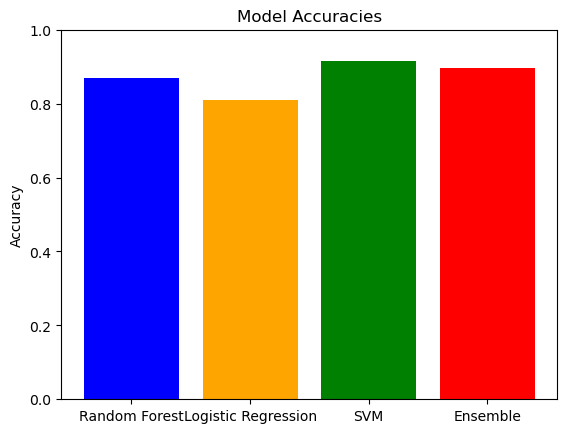

In [3]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Create a synthetic dataset for demonstration purposes
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_clusters_per_class=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create individual models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = LogisticRegression(random_state=42)
model3 = SVC(probability=True, random_state=42)

# Fit individual models
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

# Make predictions on the test set
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

# Create an ensemble using VotingClassifier
ensemble_model = VotingClassifier(estimators=[('rf', model1), ('lr', model2), ('svc', model3)], voting='soft')

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions with the ensemble model
ensemble_pred = ensemble_model.predict(X_test)

# Evaluate individual models
print("Random Forest Accuracy:", accuracy_score(y_test, pred1))
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred2))
print("SVM Accuracy:", accuracy_score(y_test, pred3))

# Corrected XGBoost accuracy evaluation
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_pred))

# Bar plot for individual models and ensemble
labels = ['Random Forest', 'Logistic Regression', 'SVM', 'Ensemble']
accuracies = [accuracy_score(y_test, pred1), accuracy_score(y_test, pred2), accuracy_score(y_test, pred3), accuracy_score(y_test, ensemble_pred)]

plt.bar(labels, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits to be between 0 and 1 for accuracy
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()


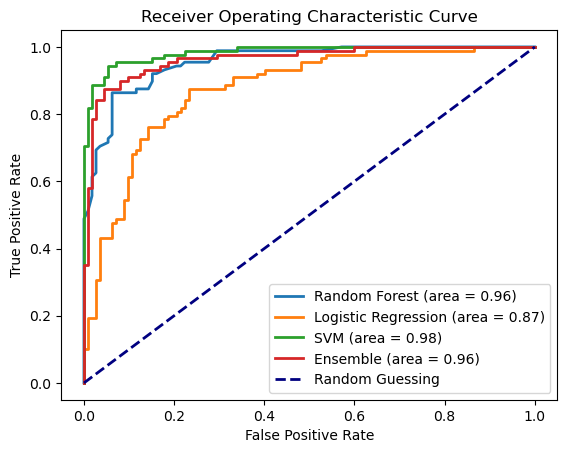

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_probs, label):
    fpr, tpr, _ = roc_curve(label_binarize(y_true, classes=[0, 1]), y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

# Individual models
plot_roc_curve(y_test, model1.predict_proba(X_test), label='Random Forest')
plot_roc_curve(y_test, model2.predict_proba(X_test), label='Logistic Regression')
plot_roc_curve(y_test, model3.predict_proba(X_test), label='SVM')

# Ensemble model
plot_roc_curve(y_test, ensemble_model.predict_proba(X_test), label='Ensemble')

# Plotting the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2, label='Random Guessing')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


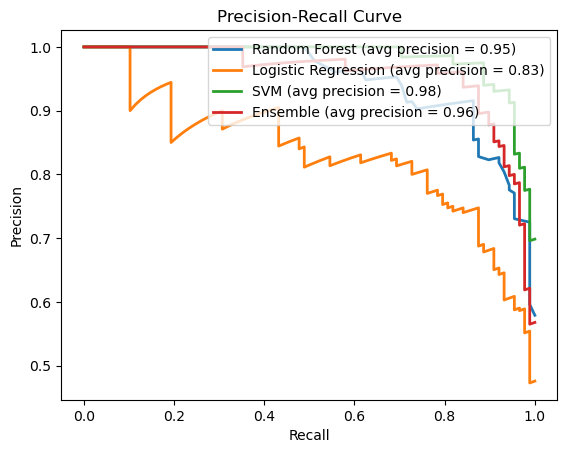

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_probs, label):
    precision, recall, _ = precision_recall_curve(label_binarize(y_true, classes=[0, 1]), y_pred_probs[:, 1])
    avg_precision = average_precision_score(y_true, y_pred_probs[:, 1])
    plt.plot(recall, precision, lw=2, label=f'{label} (avg precision = {avg_precision:.2f})')

# Individual models
plot_precision_recall_curve(y_test, model1.predict_proba(X_test), label='Random Forest')
plot_precision_recall_curve(y_test, model2.predict_proba(X_test), label='Logistic Regression')
plot_precision_recall_curve(y_test, model3.predict_proba(X_test), label='SVM')

# Ensemble model
plot_precision_recall_curve(y_test, ensemble_model.predict_proba(X_test), label='Ensemble')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


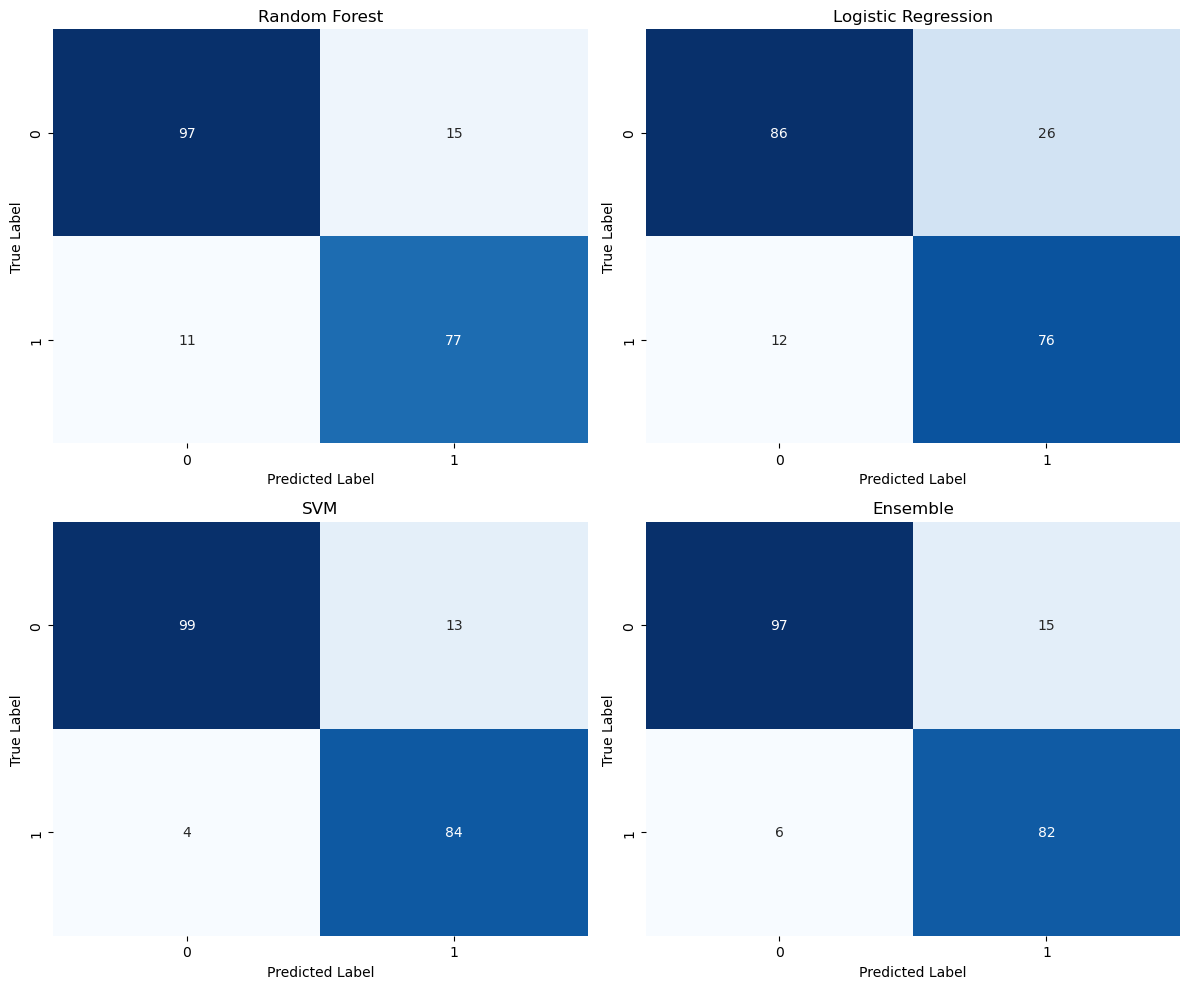

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix as a count plot
def plot_confusion_matrix(y_true, y_pred, ax, title):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, model1.predict(X_test), axes[0, 0], title='Random Forest')

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, model2.predict(X_test), axes[0, 1], title='Logistic Regression')

# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, model3.predict(X_test), axes[1, 0], title='SVM')

# Plot confusion matrix for Ensemble
plot_confusion_matrix(y_test, ensemble_model.predict(X_test), axes[1, 1], title='Ensemble')

# Adjust layout
plt.tight_layout()
plt.show()
